<a href="https://colab.research.google.com/github/HamedFarahani89/AI-Lab/blob/main/LSTTM_GRU_DUDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import torch
import torch.nn as nn
import numpy as np

# for printing out status reports
import sys

# for data visualization
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

<ipython-input-24-9def915a290b>:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


#LSTM

In [25]:
class LSTMnet(nn.Module):
  def __init__(self,input_size,num_hidden,num_layers):
    super().__init__()

    # store parameters
    self.input_size = input_size
    self.num_hidden = num_hidden
    self.num_layers = num_layers

    # RNN Layer (notation: LSTM \in RNN)
    self.lstm = nn.LSTM(input_size,num_hidden,num_layers)

    # linear layer for output
    self.out = nn.Linear(num_hidden,1)

  def forward(self,x):


    # run through the RNN layer
    y,hidden = self.lstm(x)


    # pass the RNN output through the linear output layer
    o = self.out(y)


    return o,hidden

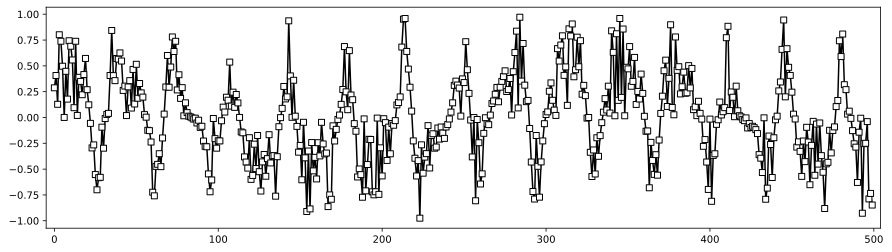

In [26]:
# import the data
N = 500

time = torch.linspace(0,30*np.pi,N)
data = torch.rand(N) * torch.sin(torch.rand(1) * time+torch.cos(torch.rand(1) * time))

plt.figure(figsize=(15,4))
plt.plot(data,'ks-',markerfacecolor='w')
plt.xlim([-5,N+4])
plt.show()

In [27]:
# network parameters
input_size =  1 # "channels" of data
num_hidden =  100 # breadth of model (number of units in hidden layers)
num_layers =  1 # depth of model (number of "stacks" of hidden layers)
seqlength  =  50 # number of datapoints used for learning in each segment
batchsize  =  1 # Note: the training code is actually hard-coded to organize data into batchsize=1


# create an instance of the model and inspect
net = LSTMnet(input_size,num_hidden,num_layers)

X = torch.rand(seqlength,batchsize,input_size)
y,h = net(X)
print(X.shape)
print(y.shape) # note: one output per sequence element; generally, we take the final output to force a "many-to-one" design.


torch.Size([50, 1, 1])
torch.Size([50, 1, 1])


In [31]:
# number of training epochs
numepochs = 150

# create a new instance of the model (and optimizer!)
optimizer = torch.optim.SGD(net.parameters(),lr=.001)
lossfun = nn.MSELoss()



# initialize losses
losses = np.zeros(numepochs)
signaccuracy = np.zeros(numepochs)

# loop over epochs
for epochi in range(numepochs):

  # loop over data segments
  seglosses = []
  segacc    = []
  hidden_state = torch.zeros(num_layers,batchsize,num_hidden) # reset the hidden state on each epoch

  for timei in range(N-seqlength):

    # grab a snippet of data
    X = data[timei:timei+seqlength].view(seqlength,1,1)
    y = data[timei+seqlength].view(1,1)

    # forward pass and loss
    yHat,hidden_state = net(X)
    finalValue = yHat[-1]
    loss = lossfun(finalValue,y) # compare final value of output

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # loss from this segment
    seglosses.append(loss.item())

    # also get sign accuracy
    truesign = np.sign(torch.squeeze(y).numpy())
    predsign = np.sign(torch.squeeze(finalValue).detach().numpy())
    accuracy = 100*(truesign==predsign)
    segacc.append(accuracy)

  # average losses from this epoch
  losses[epochi] = np.mean(seglosses)
  signaccuracy[epochi] = np.mean(segacc)

  msg = f'Finished epoch {epochi+1}/{numepochs}'
  sys.stdout.write('\r' + msg)

Finished epoch 150/150

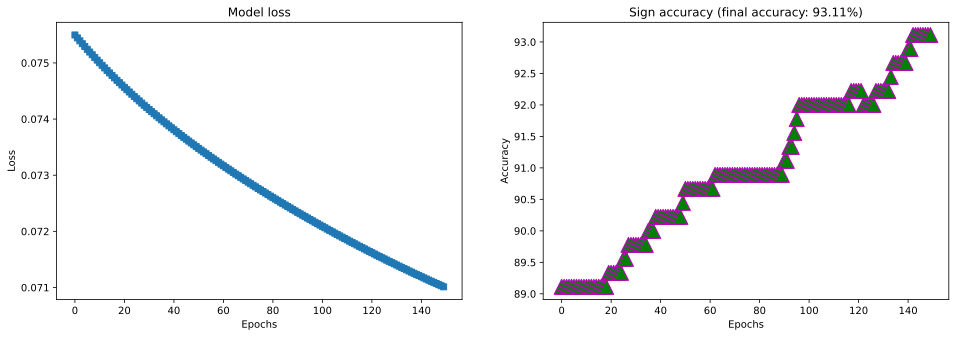

In [32]:
## let's see how the model did!

fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(signaccuracy,'m^-',markerfacecolor='g',markersize=15)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Sign accuracy (final accuracy: %.2f%%)'%signaccuracy[-1])

plt.show()

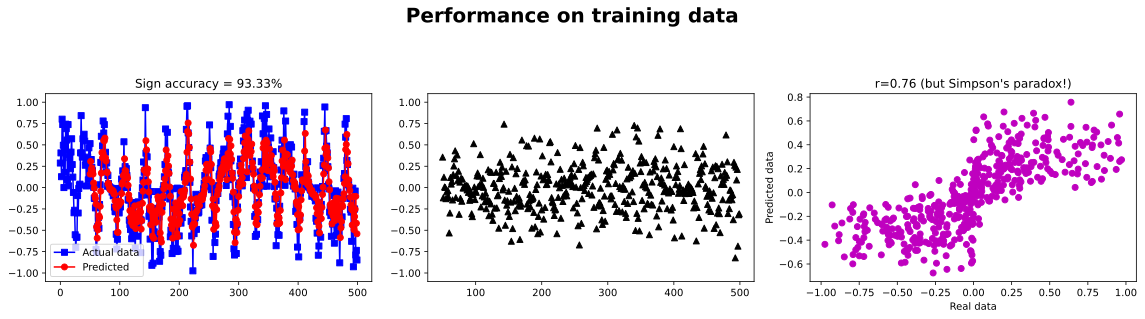

In [33]:
# initialize hidden state
h = np.zeros((N,num_hidden))

# initialize predicted values
yHat = np.zeros(N)
yHat[:] = np.nan


# loop over time segments
for timei in range(N-seqlength):

  # grab a snippet of data
  X = data[timei:timei+seqlength].view(seqlength,1,1)

  # forward pass and loss
  yy,hh = net(X)
  yHat[timei+seqlength] = yy[-1]
  # h[timei+seqlength,:] = hh.detach()


## compute sign-accuracy
truesign = np.sign(data.numpy())
predsign = np.sign(yHat)
signaccuracy = 100*np.mean(truesign[seqlength:]==predsign[seqlength:])


## plot!
fig,ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(data,'bs-',label='Actual data')
ax[0].plot(yHat,'ro-',label='Predicted')
ax[0].set_ylim([-1.1,1.1])
ax[0].set_title('Sign accuracy = %.2f%%' %signaccuracy)
ax[0].legend()

ax[1].plot(data-yHat,'k^')
ax[1].set_ylim([-1.1,1.1])

ax[2].plot(data[seqlength:],yHat[seqlength:],'mo')
ax[2].set_xlabel('Real data')
ax[2].set_ylabel('Predicted data')
r = np.corrcoef(data[seqlength:],yHat[seqlength:])
ax[2].set_title(f"r={r[0,1]:.2f} (but Simpson's paradox!)")

plt.suptitle('Performance on training data',fontweight='bold',fontsize=20,y=1.1)
plt.tight_layout()
plt.show()

#GRU

In [39]:
class GRUnet(nn.Module):
  def __init__(self,input_size,num_hidden,num_layers):
    super().__init__()

    # store parameters
    self.input_size = input_size
    self.num_hidden = num_hidden
    self.num_layers = num_layers

    # RNN Layer (notation: LSTM \in RNN)
    self.lstm = nn.GRU(input_size,num_hidden,num_layers)

    # linear layer for output
    self.out = nn.Linear(num_hidden,1)

  def forward(self,x):


    # run through the RNN layer
    y,hidden = self.lstm(x)


    # pass the RNN output through the linear output layer
    o = self.out(y)


    return o,hidden

In [45]:
# network parameters
input_size =  1 # "channels" of data
num_hidden =  100 # breadth of model (number of units in hidden layers)
num_layers =  1 # depth of model (number of "stacks" of hidden layers)
seqlength  =  50 # number of datapoints used for learning in each segment
batchsize  =  1 # Note: the training code is actually hard-coded to organize data into batchsize=1

# number of training epochs
numepochs = 50

Gnet = GRUnet(input_size,num_hidden,num_layers)

# create a new instance of the model (and optimizer!)
optimizer = torch.optim.SGD(Gnet.parameters(),lr=.001)
lossfun = nn.MSELoss()



# initialize losses
losses = np.zeros(numepochs)
signaccuracy = np.zeros(numepochs)

# loop over epochs
for epochi in range(numepochs):

  # loop over data segments
  seglosses = []
  segacc    = []
  hidden_state = torch.zeros(num_layers,batchsize,num_hidden) # reset the hidden state on each epoch

  for timei in range(N-seqlength):

    # grab a snippet of data
    X = data[timei:timei+seqlength].view(seqlength,1,1)
    y = data[timei+seqlength].view(1,1)

    # forward pass and loss
    yHat,hidden_state = Gnet(X)
    finalValue = yHat[-1]
    loss = lossfun(finalValue,y) # compare final value of output

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # loss from this segment
    seglosses.append(loss.item())

    # also get sign accuracy
    truesign = np.sign(torch.squeeze(y).numpy())
    predsign = np.sign(torch.squeeze(finalValue).detach().numpy())
    accuracy = 100*(truesign==predsign)
    segacc.append(accuracy)

  # average losses from this epoch
  losses[epochi] = np.mean(seglosses)
  signaccuracy[epochi] = np.mean(segacc)

  msg = f'Finished epoch {epochi+1}/{numepochs}'
  sys.stdout.write('\r' + msg)

Finished epoch 50/50

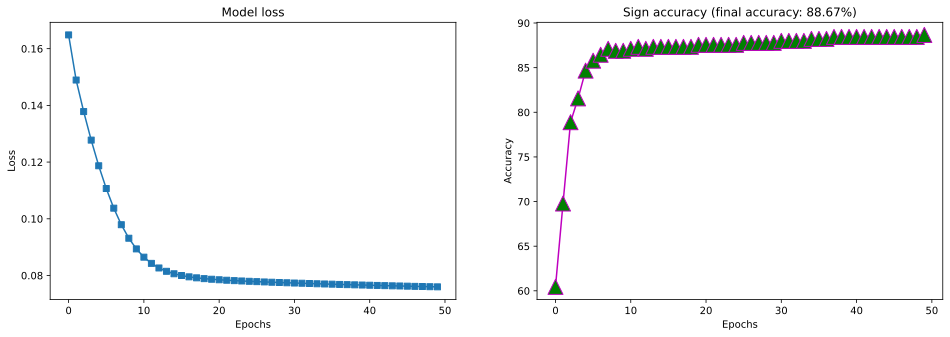

In [46]:
## let's see how the model did!

fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(signaccuracy,'m^-',markerfacecolor='g',markersize=15)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Sign accuracy (final accuracy: %.2f%%)'%signaccuracy[-1])

plt.show()

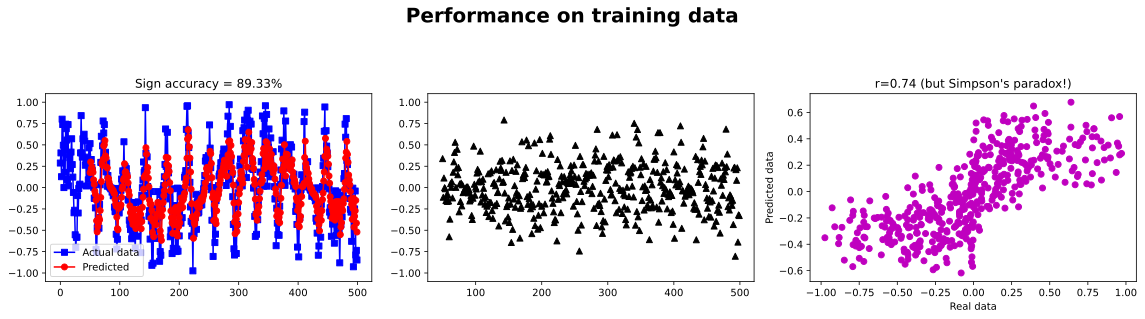

In [47]:
# initialize hidden state
h = np.zeros((N,num_hidden))

# initialize predicted values
yHat = np.zeros(N)
yHat[:] = np.nan


# loop over time segments
for timei in range(N-seqlength):

  # grab a snippet of data
  X = data[timei:timei+seqlength].view(seqlength,1,1)

  # forward pass and loss
  yy,hh = Gnet(X)
  yHat[timei+seqlength] = yy[-1]
  # h[timei+seqlength,:] = hh.detach()


## compute sign-accuracy
truesign = np.sign(data.numpy())
predsign = np.sign(yHat)
signaccuracy = 100*np.mean(truesign[seqlength:]==predsign[seqlength:])


## plot!
fig,ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(data,'bs-',label='Actual data')
ax[0].plot(yHat,'ro-',label='Predicted')
ax[0].set_ylim([-1.1,1.1])
ax[0].set_title('Sign accuracy = %.2f%%' %signaccuracy)
ax[0].legend()

ax[1].plot(data-yHat,'k^')
ax[1].set_ylim([-1.1,1.1])

ax[2].plot(data[seqlength:],yHat[seqlength:],'mo')
ax[2].set_xlabel('Real data')
ax[2].set_ylabel('Predicted data')
r = np.corrcoef(data[seqlength:],yHat[seqlength:])
ax[2].set_title(f"r={r[0,1]:.2f} (but Simpson's paradox!)")

plt.suptitle('Performance on training data',fontweight='bold',fontsize=20,y=1.1)
plt.tight_layout()
plt.show()